In [4]:
import matplotlib.pyplot as plt
import numpy as np
from utils import compute_coverage
from glob import glob
import pandas as pd
import seaborn as sns
from scipy.stats import norm

In [5]:
11 % 10

1

In [6]:
saved_batches = list(np.arange(0, 51, 10)) 

In [7]:
saved_batches

[0, 10, 20, 30, 40, 50]

In [8]:
confidence = 0.95
ci = norm.ppf((1-confidence)/2 + confidence)

In [9]:
def concat_df(estimate, cov_sqrt_inv, weights, saved_batches, param_truth, df, **kwargs):
    """
    estimate: (n_batches, n_params)
    """
    n_batches, n_params = estimate.shape
    error = (estimate - param_truth)
    std = compute_std(cov_sqrt_inv)
    tstat = compute_tstat(error, cov_sqrt_inv)
    tstat_param = error / std
    cov = np.asarray(np.abs(tstat) < ci, dtype=np.float64)
    cov_param = np.asarray(np.abs(tstat_param) < ci, dtype=np.float64)
    df_b = pd.DataFrame(dict(estimate=estimate.flatten(),
                                               std=std.flatten(),
                                               mse=np.square(error).flatten(),
                                               error=error.flatten(),
                                               tstat=tstat.flatten(),
                                               tstat_param=tstat_param.flatten(),
                                               cov=cov.flatten(),
                                               cov_param=cov_param.flatten(),
                                               weights=[weights] * (n_batches * n_params),
                                               batch=np.repeat(saved_batches, n_params).flatten(),
                                               params=np.tile(np.arange(n_params), n_batches).flatten()))
    for k, v in kwargs.items():
        df_b[k] = v
    new_df =  pd.concat([df, df_b], ignore_index=True)
    return new_df

In [10]:
def compute_std(mat):
    std = []
    for m in mat:
        minv = np.linalg.inv(m)
        std.append(np.sqrt(np.diag(np.matmul(minv, minv.T))))
    return np.array(std)

In [11]:
def compute_tstat(error, mat):
    tstat = [np.matmul(m, e) for m, e in zip(mat, error)]
    return np.array(tstat)

In [12]:
def get_param_df(path_name):
    estimate_df = pd.DataFrame()
    flag=True
    for path in glob(path_name):
        results = np.load(path)
        truth = results['thetas'][saved_batches]
        estimate_df = concat_df(results['naive_Theta'][saved_batches], results['naive_Cov_sqrt_inv'][saved_batches], 'naive', 
                                saved_batches, truth, estimate_df,  floor_decay=results['floor_decay'], noise_dis=results['noise_dis'], noise_std=results['noise_std'])
        estimate_df = concat_df(results['consistent_Theta'][saved_batches], results['consistent_Cov_sqrt_inv'][saved_batches], 'consistent', 
                                saved_batches, truth, estimate_df,  floor_decay=results['floor_decay'], noise_dis=results['noise_dis'], noise_std=results['noise_std'])
        estimate_df = concat_df(results['oracle_Theta'][saved_batches], results['oracle_Cov_sqrt_inv'][saved_batches], 'oracle', 
                                saved_batches, truth, estimate_df, floor_decay=results['floor_decay'], noise_dis=results['noise_dis'], noise_std=results['noise_std'])
        estimate_df = concat_df(results['feasible_Theta'][saved_batches], results['feasible_Cov_sqrt_inv'][saved_batches], 'feasible', 
                                saved_batches, truth, estimate_df,  floor_decay=results['floor_decay'], noise_dis=results['noise_dis'], noise_std=results['noise_std'])
    return estimate_df




In [13]:
from matplotlib import rcParams
rcParams['text.usetex'] = False
def plot(df, stat, baselines=None, col='params', col_wrap=5, estimator=np.mean, yname=None):
    g = sns.catplot(data=df, col_wrap=col_wrap, hue='weights', x='batch', y=stat, col=col, kind='point', estimator=estimator)
    titles = ['$theta_0$', '$theta_{1,1}$', '$theta_{1,2}$', '$theta_{2,1}$', '$theta_{2,2}$']
    for k in range(5):
        ax = g.axes.flatten()[k]
        ax.set_title(titles[k], fontsize=15)
        ax.set_ylabel(yname, fontsize=12)
        ax.set_xlabel('Batch', fontsize=12)
        if baselines is not None:
            ax.axhline(baselines[k], ls='--', c='k')
            
    
# sanity check the matrix-weighted vector: bias of moment

## 1. Without misspecification

In [33]:
df_params = get_param_df("./results/gmm_lasso*.npz")

In [54]:
df_params

,estimate,std,mse,error,tstat,tstat_param,cov,cov_param,weights,batch,params,floor_decay,noise_dis,noise_std,params_name
0,-0.191424,0.119023,0.036643,-0.191424,-2.274645,-1.608296,0.0,1.0,naive,0,0,0.5,uniform,1.0,$theta_0$
1,0.449969,0.397938,0.013458,-0.116010,-0.131195,-0.291528,1.0,1.0,naive,0,1,0.5,uniform,1.0,"$theta_{1,1}$"
2,0.205007,0.694088,0.056945,0.238631,0.301432,0.343805,1.0,1.0,naive,0,2,0.5,uniform,1.0,"$theta_{1,2}$"
3,0.253497,0.131382,0.112526,-0.335448,-2.834388,-2.553235,0.0,0.0,naive,0,3,0.5,uniform,1.0,"$theta_{2,1}$"
4,1.051304,0.059912,0.024107,0.155265,3.177357,2.591545,0.0,0.0,naive,0,4,0.5,uniform,1.0,"$theta_{2,2}$"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8635,0.043870,0.028141,0.001925,0.043870,0.495758,1.558956,1.0,1.0,feasible,50,0,0.5,uniform,1.0,$theta_0$
8636,0.235104,0.119990,0.008831,0.093973,0.878699,0.783171,1.0,1.0,feasible,50,1,0.5,uniform,1.0,"$theta_{1,1}$"
8637,-0.602587,0.162517,0.067367,-0.259551,-1.602344,-1.597073,1.0,1.0,feasible,50,2,0.5,uniform,1.0,"$theta_{1,2}$"
8638,-0.111027,0.062034,0.004564,0.067554,1.092890,1.088993,1.0,1.0,feasible,50,3,0.5,uniform,1.0,"$theta_{2,1}$"


In [35]:
# floor = 0.5
# noise_std = 2.0
# df_sub_0 = df_params.query(f"params==0  & floor_decay == {floor} & noise_std == {noise_std}")
# df_sub_theta = df_params.query(f"params>0  & floor_decay == {floor} & noise_std == {noise_std}")

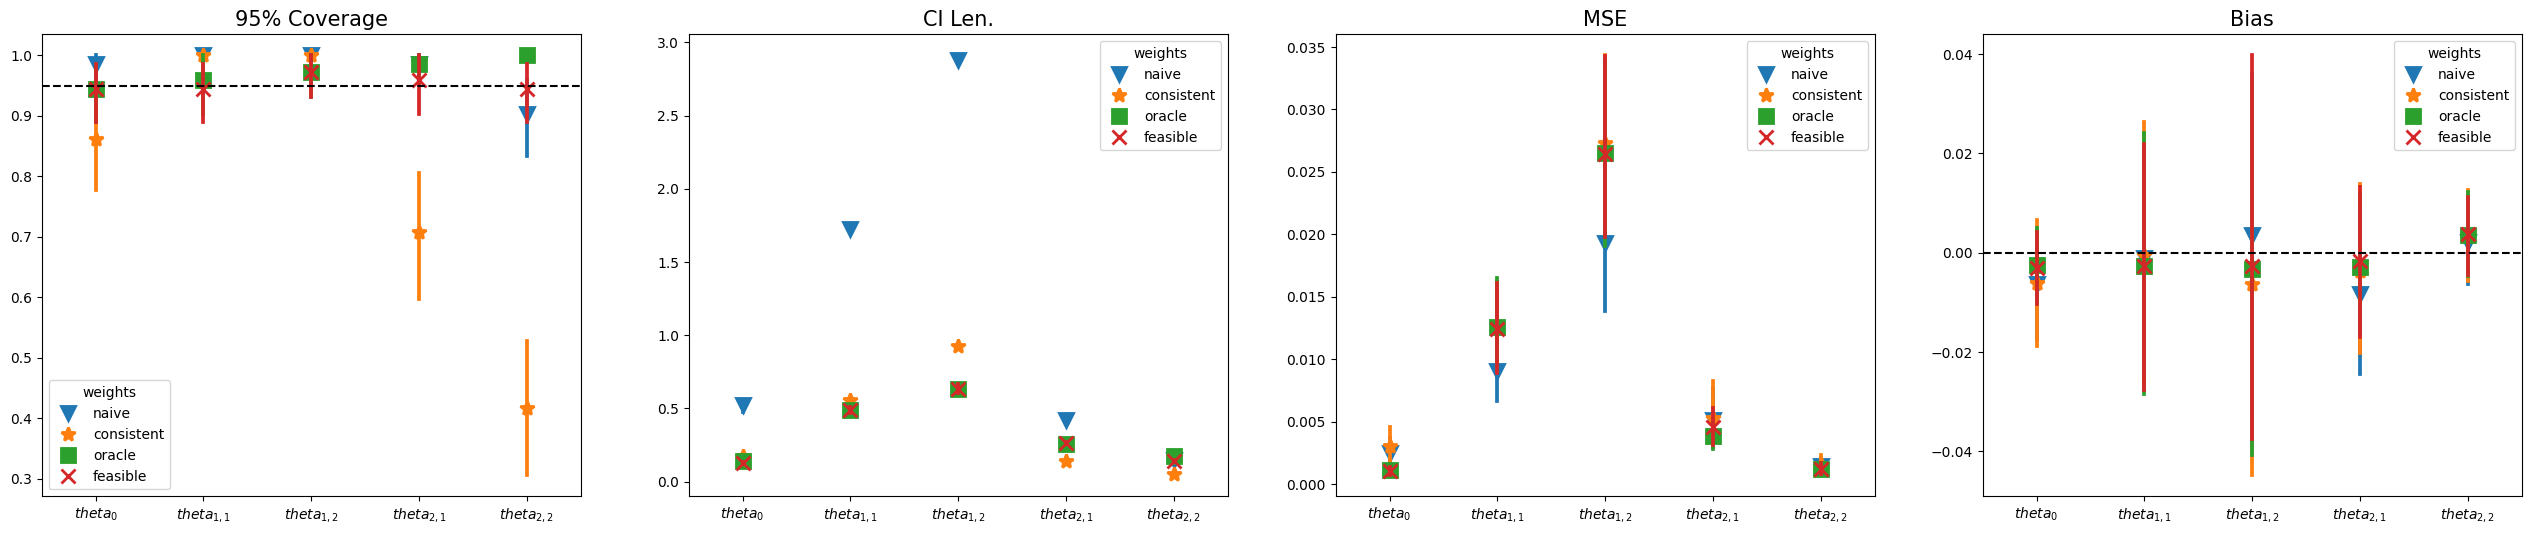

In [36]:
f, axes = plt.subplots(ncols=4, figsize=(4*8, 6))
stats = ['cov_param', 'std', 'mse', 'error']
estimators = [np.mean, lambda x:4*np.mean(x), np.mean, np.mean]
names = [f'{int(100*confidence)}% Coverage', 'CI Len.', 'MSE', 'Bias']
baselines = [confidence, None, None, 0]
x_ticklabels = ['$theta_0$', '$theta_{1,1}$', '$theta_{1,2}$', '$theta_{2,1}$', '$theta_{2,2}$']
for ax, stat, estimator, name, b in zip(axes, stats, estimators, names, baselines):
    sns.pointplot(data=df_params.query("batch==50"), x='params', y=stat, hue='weights', ax=ax, estimator=estimator, markers=["v", "*", "s", "x"], linestyle='', markersize=10)
    ax.set_title(name, fontsize=15)
    ax.set_ylabel("", fontsize=12)
    ax.set_xlabel('', fontsize=12)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(x_ticklabels)
    if b is not None:
        ax.axhline(b, ls='--', c='k')
plt.savefig('./plots/lasso_last_all.pdf')

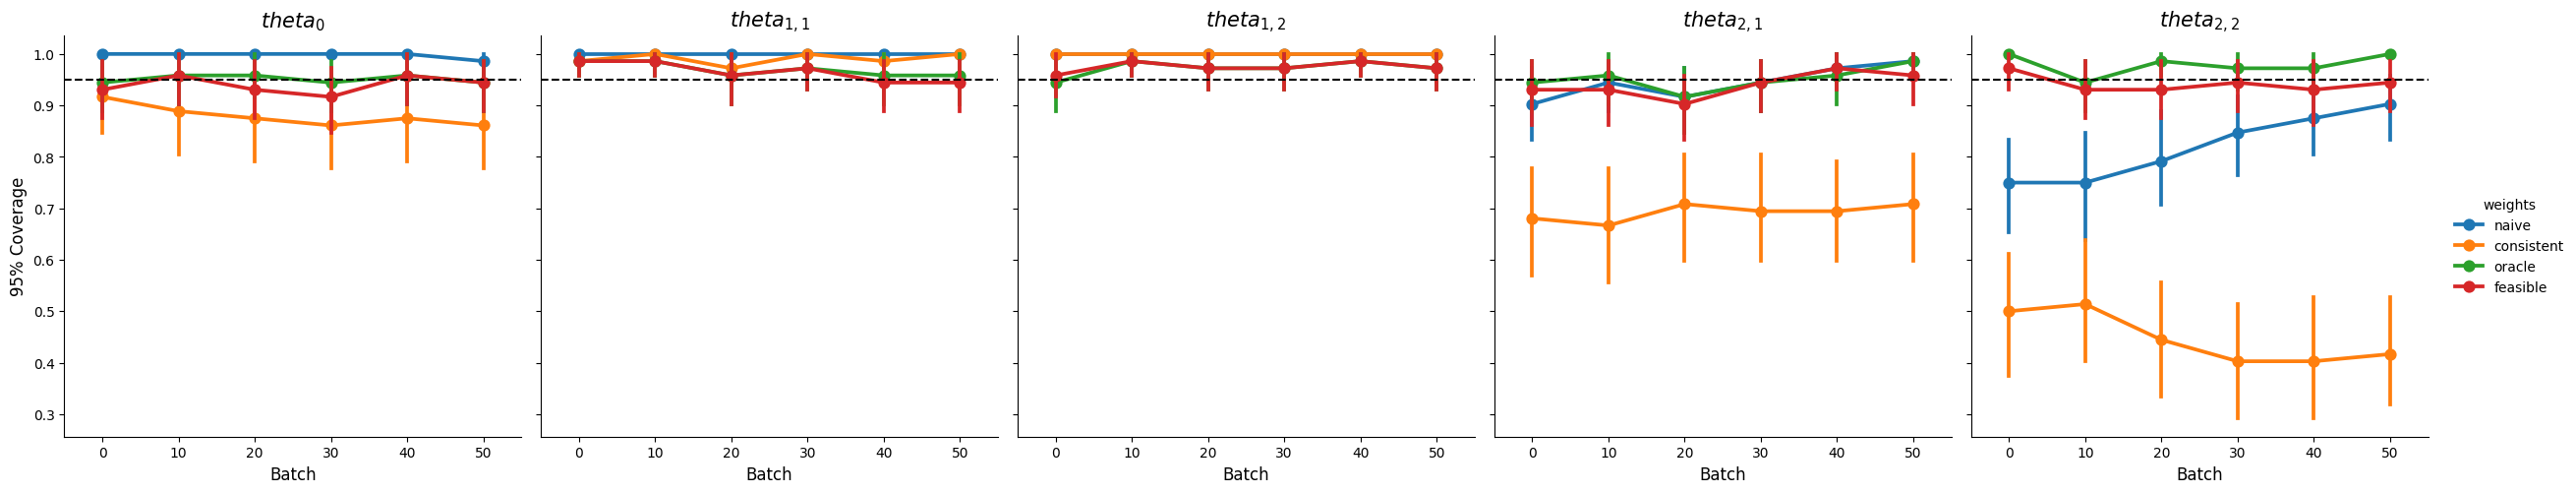

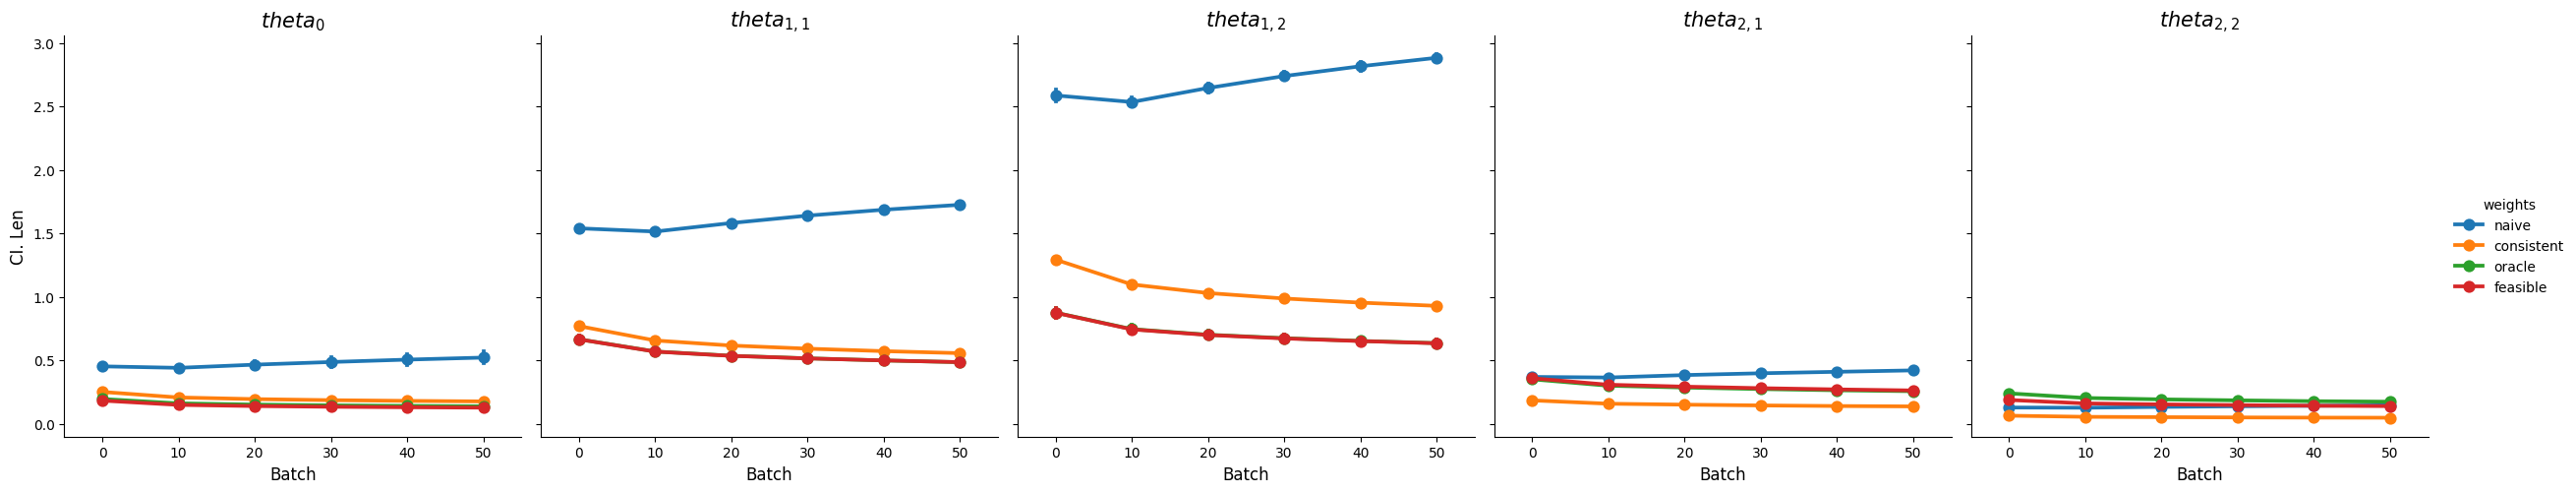

In [37]:
plot(df_params, 'cov_param', baselines=[confidence] * 5, yname=f'{int(100*confidence)}% Coverage')
plt.savefig('./plots/cov.pdf')
plot(df_params, 'std', estimator=lambda x:4*np.mean(x), yname='CI. Len')
plt.savefig('./plots/ci.pdf')

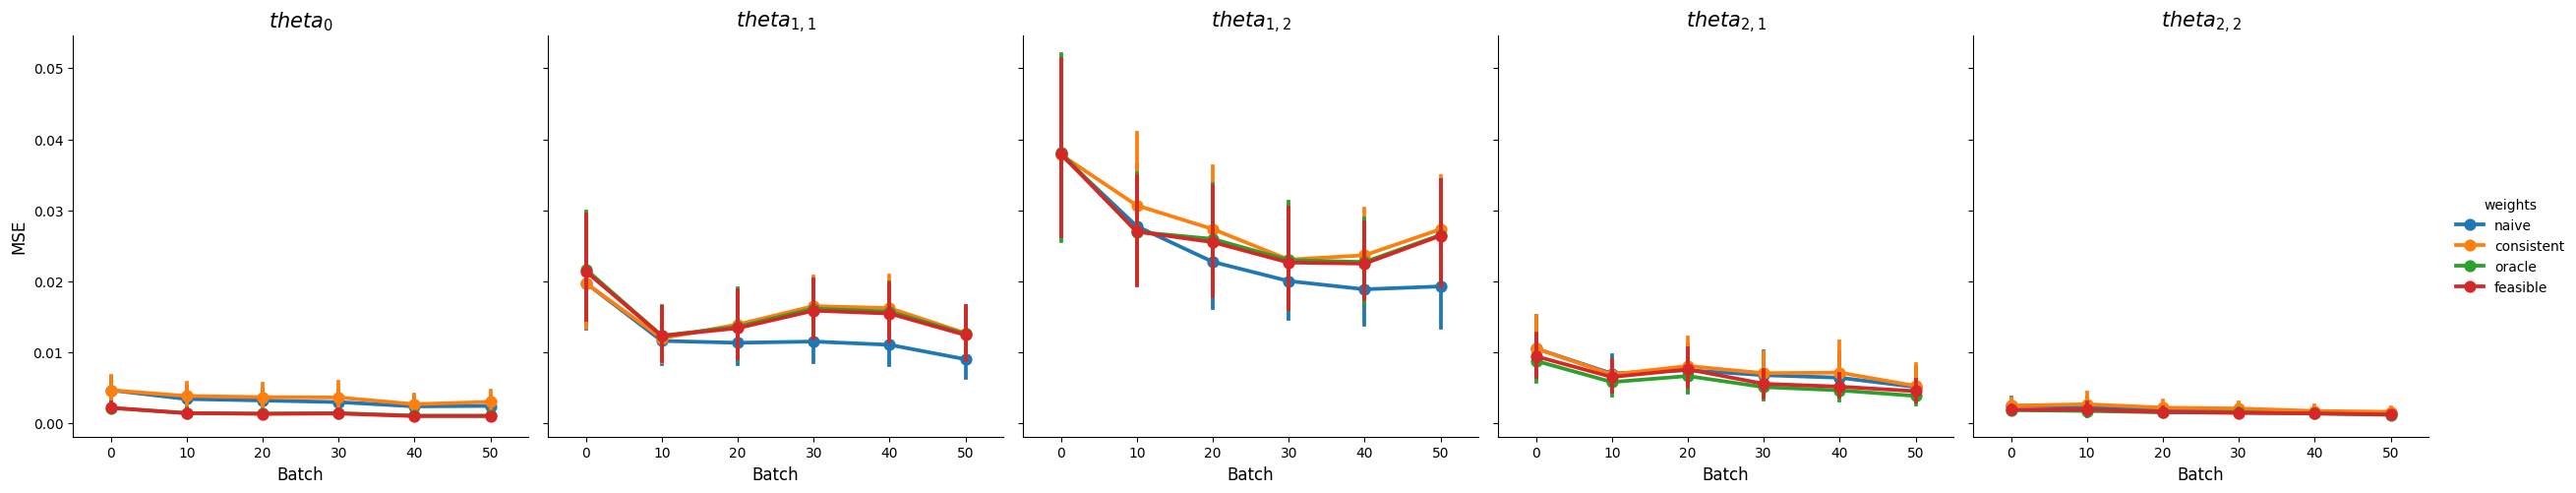

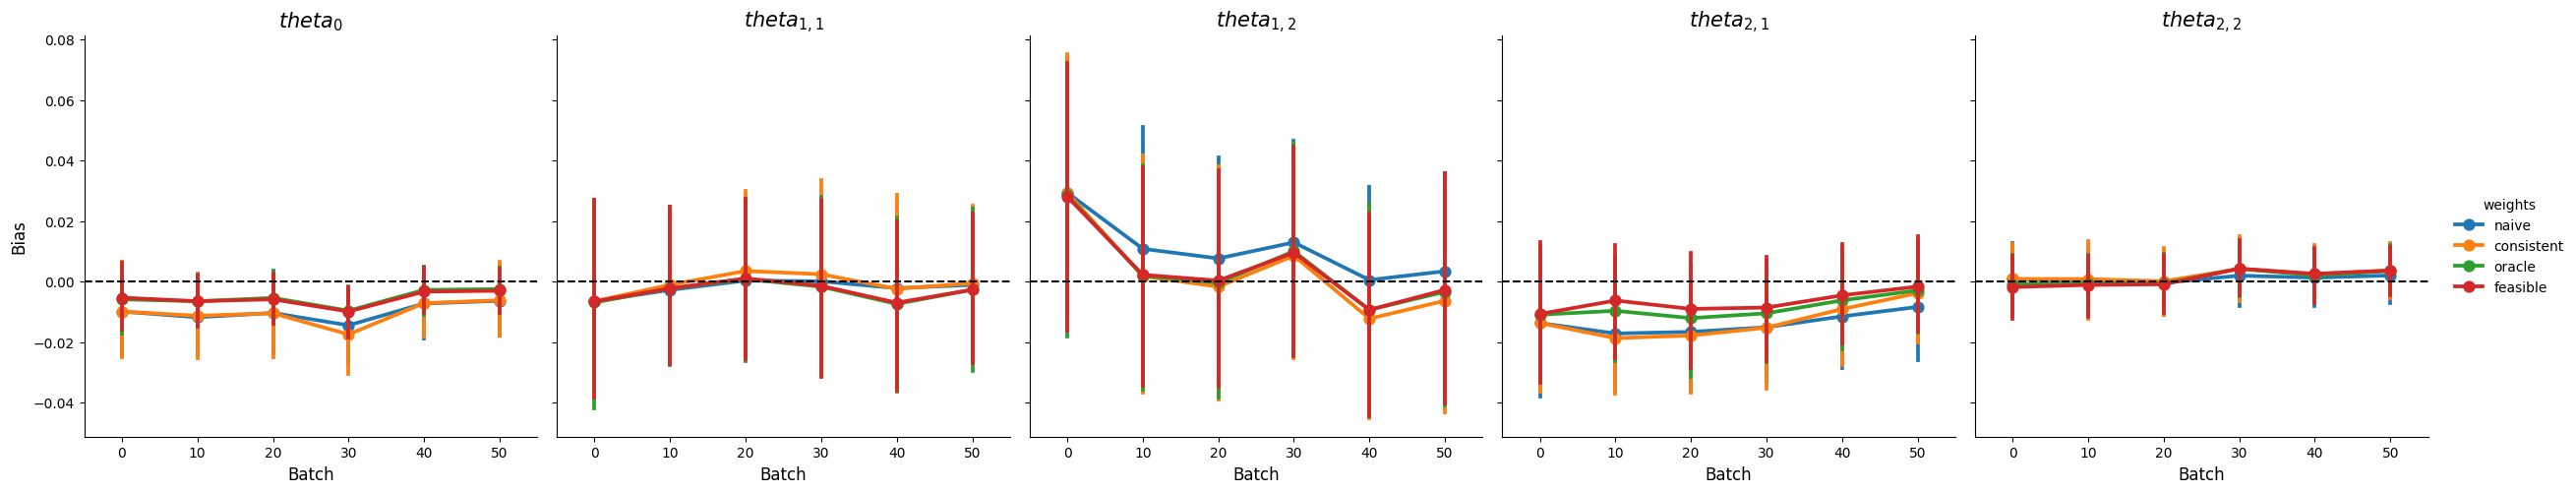

In [38]:
plot(df_params, 'mse', estimator=np.mean, yname='MSE')
plt.savefig('./plots/mse.pdf')
# plot(df_params, 'error', estimator=np.std, yname='Std')
# plt.savefig('./std.pdf')
plot(df_params, 'error', baselines=[0] * 5, yname='Bias')
plt.savefig('./plots/bias.pdf')

In [39]:
def plot_hist(df, stat, batch=None):
    from scipy.stats import norm
    if batch is None:
        batch = np.amax(saved_batches)
    name_dict = {0:'$theta_0$', 1:'$theta_{1,1}$', 2:'$theta_{1,2}$', 3:'$theta_{2,1}$', 4:'$theta_{2,2}$'}
    g = sns.FacetGrid(col="params_name",
                      row="weights",
                      sharex=True,
                      sharey=True,
                      #ylim=(0, .8),
                      xlim=(-9, 9),
                      #margin_titles=True,
                      data=df.query(f"batch=={batch}"),
                      margin_titles=True)
    g = g.map(sns.histplot, stat, kde=True, stat="density")
    g.set_titles(col_template='{col_name}', row_template="{row_name}")
    xs = np.linspace(-4, 4)
    for ax in  g.axes.flatten():
        ax.plot(xs, norm.pdf(xs),label='N(0,1)', **{"color":"black", "linestyle":"-", "linewidth":1})
        ax.set(xlabel="")
        ax.axvline(x=0, color="tab:orange", ls="--")
        ax.set_xticks([0])
    handles, labels = g._legend_data.values(), g._legend_data.keys()
    g.fig.legend(labels=['Empirical density', 'Gaussian(0,1)'],  bbox_to_anchor= (1.2, 0.5))
    g.fig.tight_layout()

In [40]:
name_dict = {0:'$theta_0$', 1:'$theta_{1,1}$', 2:'$theta_{1,2}$', 3:'$theta_{2,1}$', 4:'$theta_{2,2}$'}
df_params['params_name'] = [name_dict[i] for i in df_params.params]

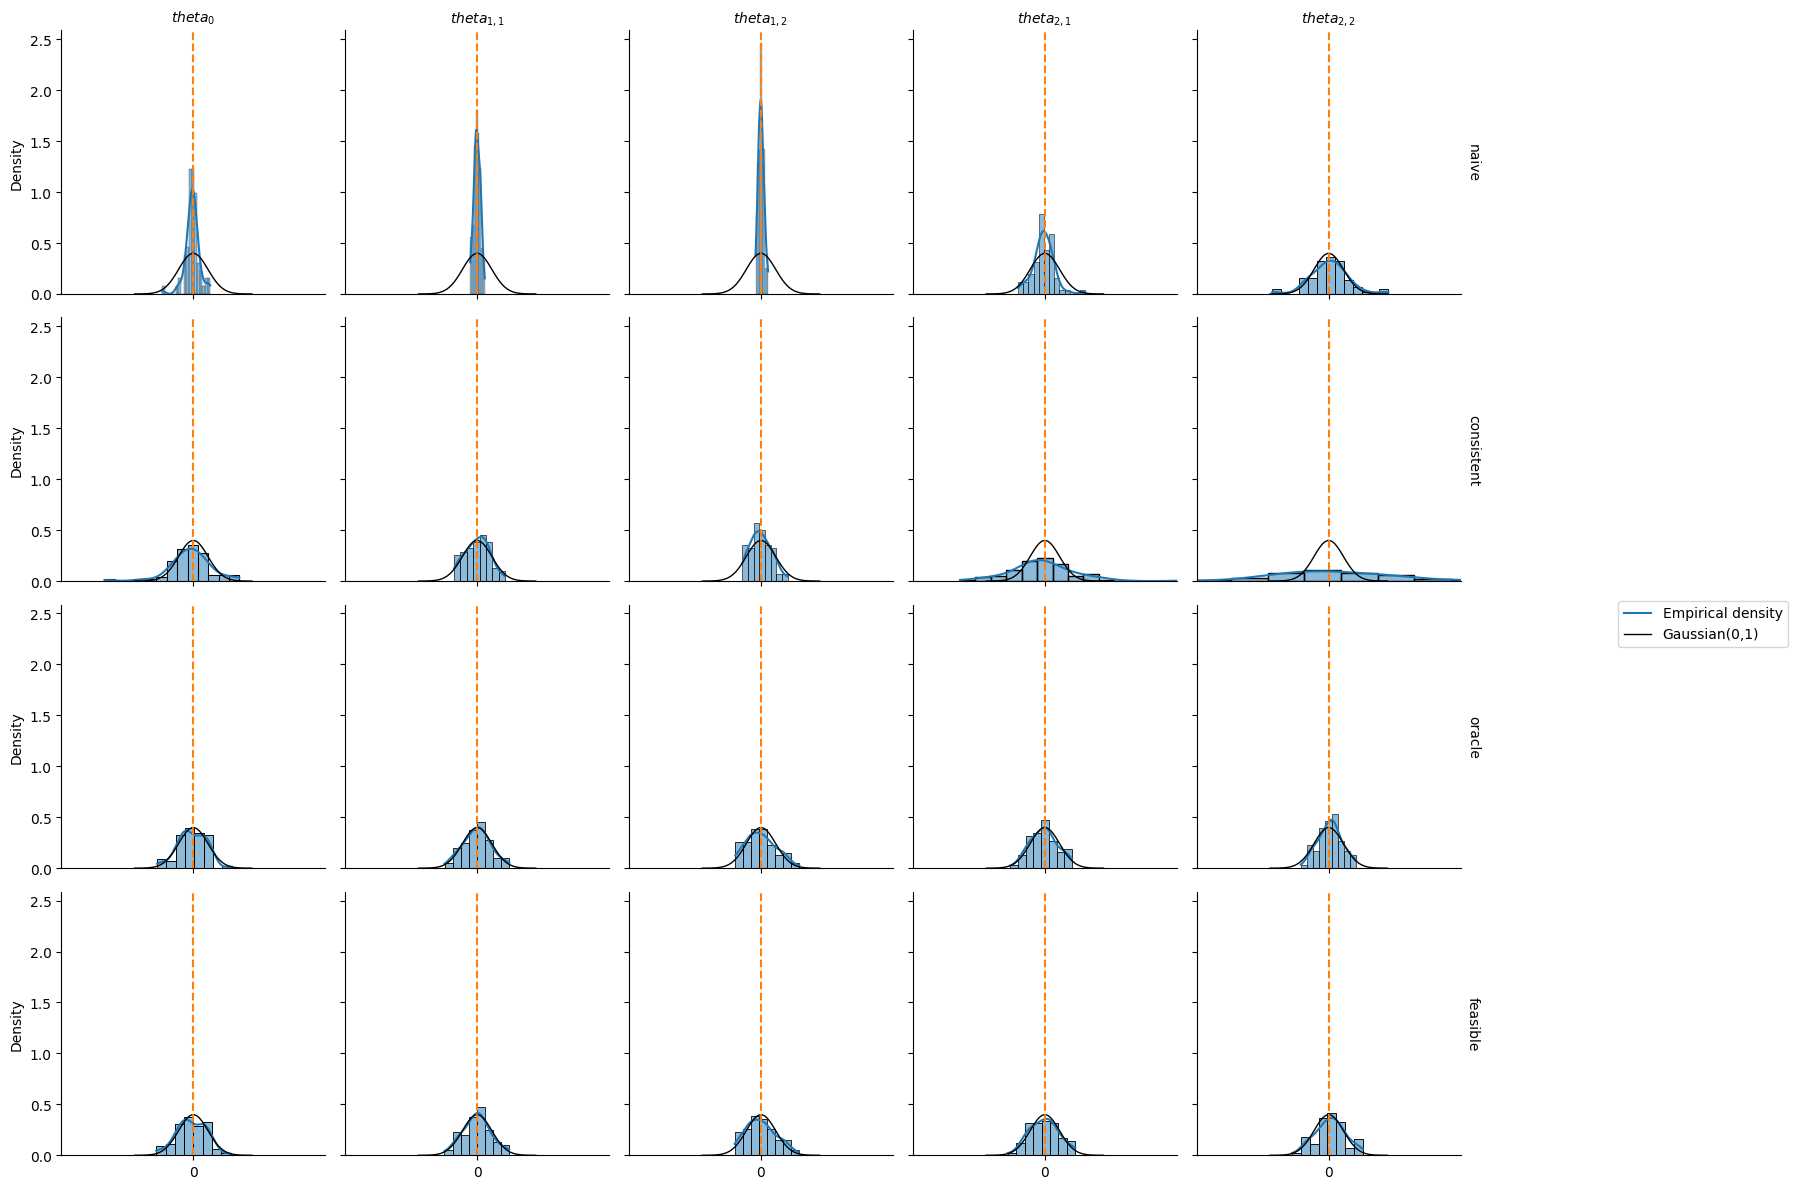

In [41]:
plot_hist(df_params, 'tstat_param')
plt.savefig('./plots/tstats_hist.pdf')

## 2. Comparison of different degrees of misspecification
DGP
- state covariate, scalar, $x\in R$
- treatment, binary, $t \in \{0,1\}$
- true feature mapping: $\phi(t,x)=e^{tx}-1$

$\phi(t,x)=e^{0.1*tx}-1$

$t * 1/(1+e^{-x})$

$(2 * sigmoid(x-c) - 1) * t$

We experiment different degrees of feature approximation:
- approx_degree = 1: $\Phi \sim (1, TX)$
- approx_degree = 2: $\Phi \sim (1, TX, (TX)^2)$

We compare _naive_, _consistent_, _feasible_ weighting schemes, and report estimation error and MSE of estimating baseline policy value.

In [42]:
def concat_df_misspec(estimate, cov_sqrt_inv, weights, saved_batches, param_truth, df, **kwargs):
    """
    estimate: (n_batches, n_params)
    """
    n_batches, n_params = estimate.shape
    error = (estimate[:,  0] - param_truth[:, 0])
    std = compute_std(cov_sqrt_inv)[:, 0]
    tstat_param = error / std
    cov_param = np.asarray(np.abs(tstat_param) < ci, dtype=np.float64)
    df_b = pd.DataFrame(dict(estimate=estimate[:, 0],
                             std=std.flatten(),
                             mse=np.square(error).flatten(),
                             error=error.flatten(),
                             tstat_param=tstat_param.flatten(),
                               cov_param=cov_param.flatten(),
                               weights=[weights] * (n_batches),
                               batch=saved_batches))
    for k, v in kwargs.items():
        df_b[k] = v
    new_df =  pd.concat([df, df_b], ignore_index=True)
    return new_df

def get_param_df_misspec(path_name):
    estimate_df = pd.DataFrame()
    flag=True
    for path in glob(path_name):
        results = np.load(path)
        truth = results['thetas'][saved_batches]
        estimate_df = concat_df_misspec(results['naive_Theta'][saved_batches], results['naive_Cov_sqrt_inv'][saved_batches], 'naive', 
                                saved_batches, truth, estimate_df,  scale=results['scale'],
                                        floor_decay=results['floor_decay'], noise_dis=results['noise_dis'], noise_std=results['noise_std'], approx_degree=results['approx_degree'])
        estimate_df = concat_df_misspec(results['consistent_Theta'][saved_batches], results['consistent_Cov_sqrt_inv'][saved_batches], 'consistent', 
                                saved_batches,  truth, estimate_df,  scale=results['scale'], floor_decay=results['floor_decay'], noise_dis=results['noise_dis'], noise_std=results['noise_std'], approx_degree=results['approx_degree'])
        estimate_df = concat_df_misspec(results['feasible_Theta'][saved_batches], results['feasible_Cov_sqrt_inv'][saved_batches], 'feasible', 
                                saved_batches, truth, estimate_df,  floor_decay=results['floor_decay'], noise_dis=results['noise_dis'], 
                                        scale=results['scale'],
                                        noise_std=results['noise_std'], approx_degree=results['approx_degree'])
    
    return estimate_df

In [43]:
df_params_misspec = get_param_df_misspec("./results/gmm_misspec*.npz")

In [53]:
np.unique(df_params_misspec.noise_dis)

array(['uniform'], dtype=object)

In [45]:
def plot_misspec(df, stat, baselines=None, col='approx_degree', col_wrap=4, estimator=np.mean, yname=None):
    g = sns.catplot(data=df, col_wrap=col_wrap, hue='weights', x='batch', y=stat, col=col, kind='point')
    titles = ['Approx.Degree = 1', 'Approx.Degree = 2', 'Approx.Degree = 3', 'Approx.Degree = 4', 'Approx.Degree = 5']
    for k in range(len(titles)):
        ax = g.axes.flatten()[k]
        ax.set_title(titles[k], fontsize=15)
        ax.set_ylabel(yname, fontsize=12)
        ax.set_xlabel('Batch', fontsize=12)
        if baselines is not None:
            ax.axhline(baselines[k], ls='--', c='k')

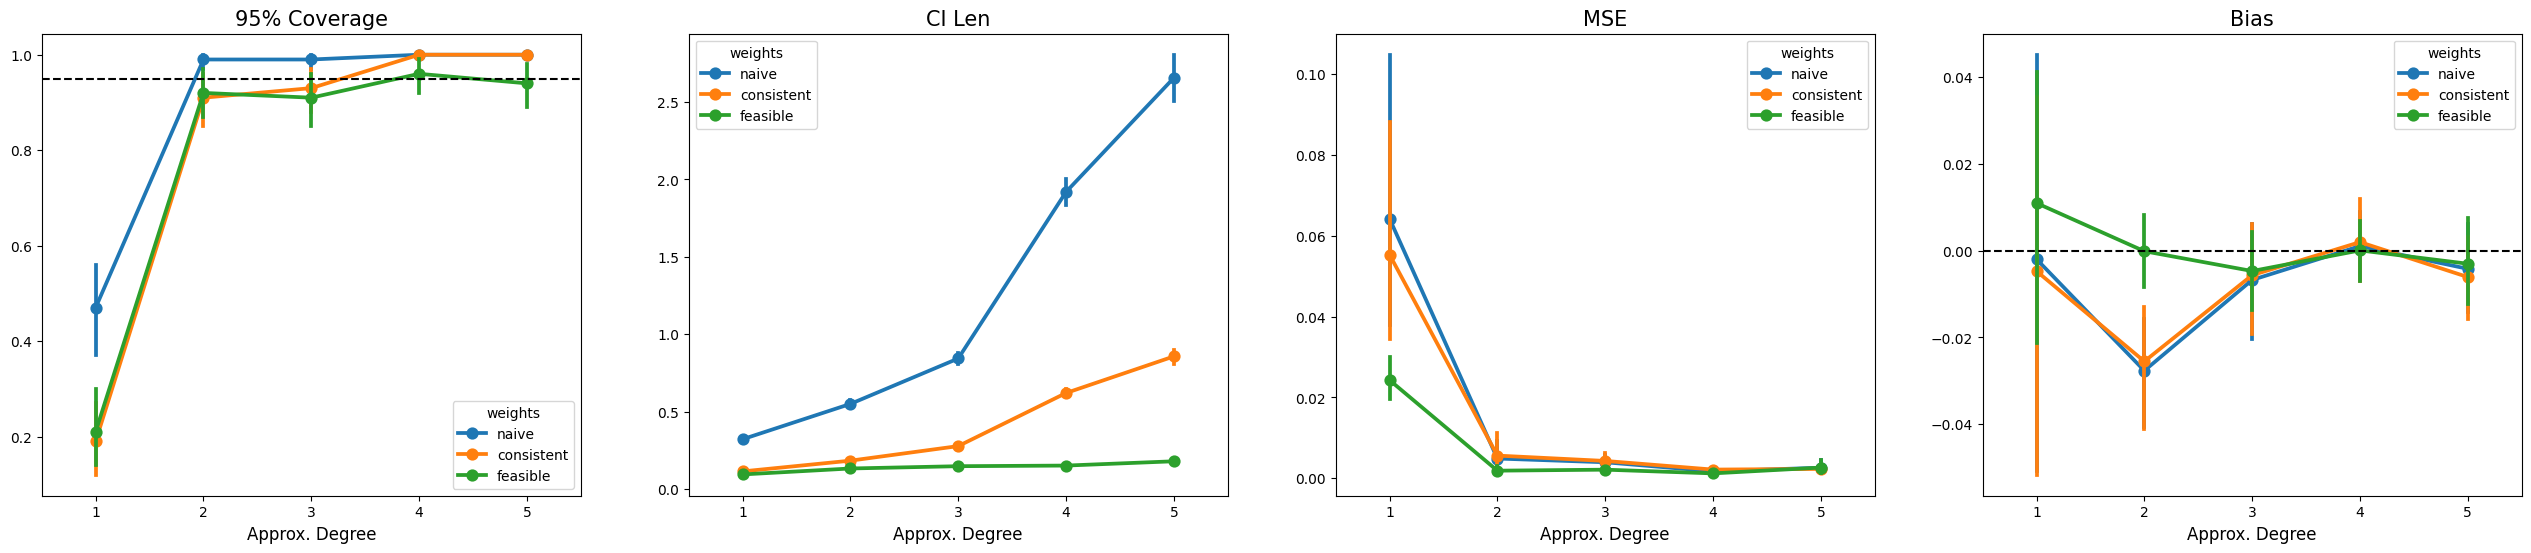

In [46]:
f, axes = plt.subplots(ncols=4, figsize=(4*8, 6))
stats = ['cov_param', 'std', 'mse', 'error']
estimators = [np.mean, lambda x:4*np.mean(x), np.mean, np.mean]
names = [f'{int(100*confidence)}% Coverage', 'CI Len', 'MSE', 'Bias']
baselines = [confidence, None, None, 0]

for ax, stat, estimator, name, b in zip(axes, stats, estimators, names, baselines):
    sns.pointplot(data=df_params_misspec.query("batch==50"), x='approx_degree', y=stat, hue='weights', ax=ax, estimator=estimator)
    ax.set_title(name, fontsize=15)
    ax.set_ylabel("", fontsize=12)
    ax.set_xlabel('Approx. Degree', fontsize=12)
    if b is not None:
        ax.axhline(b, ls='--', c='k')
plt.savefig('./plots/misspec_last_all.pdf')

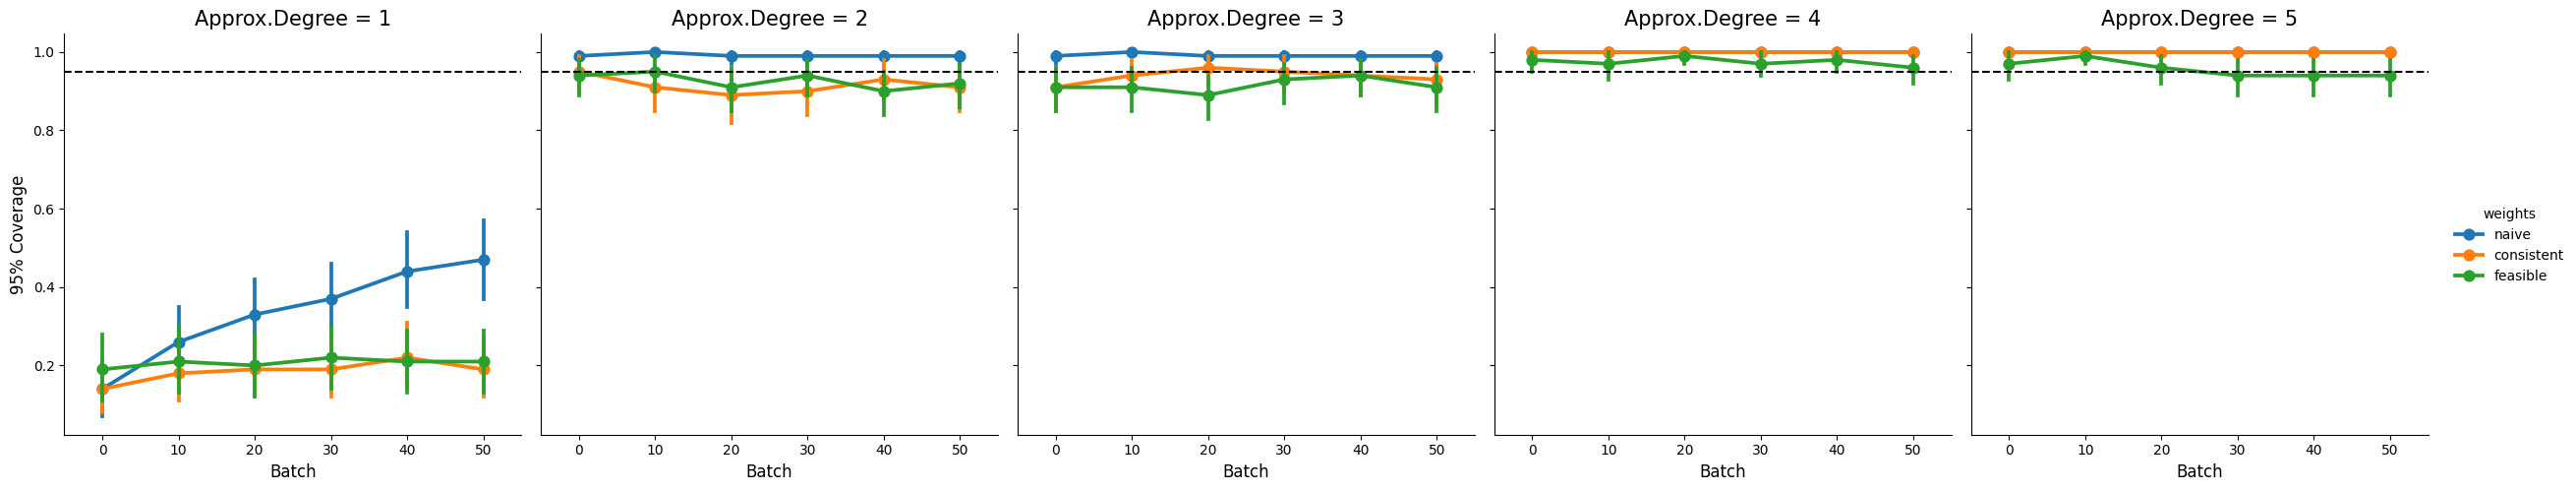

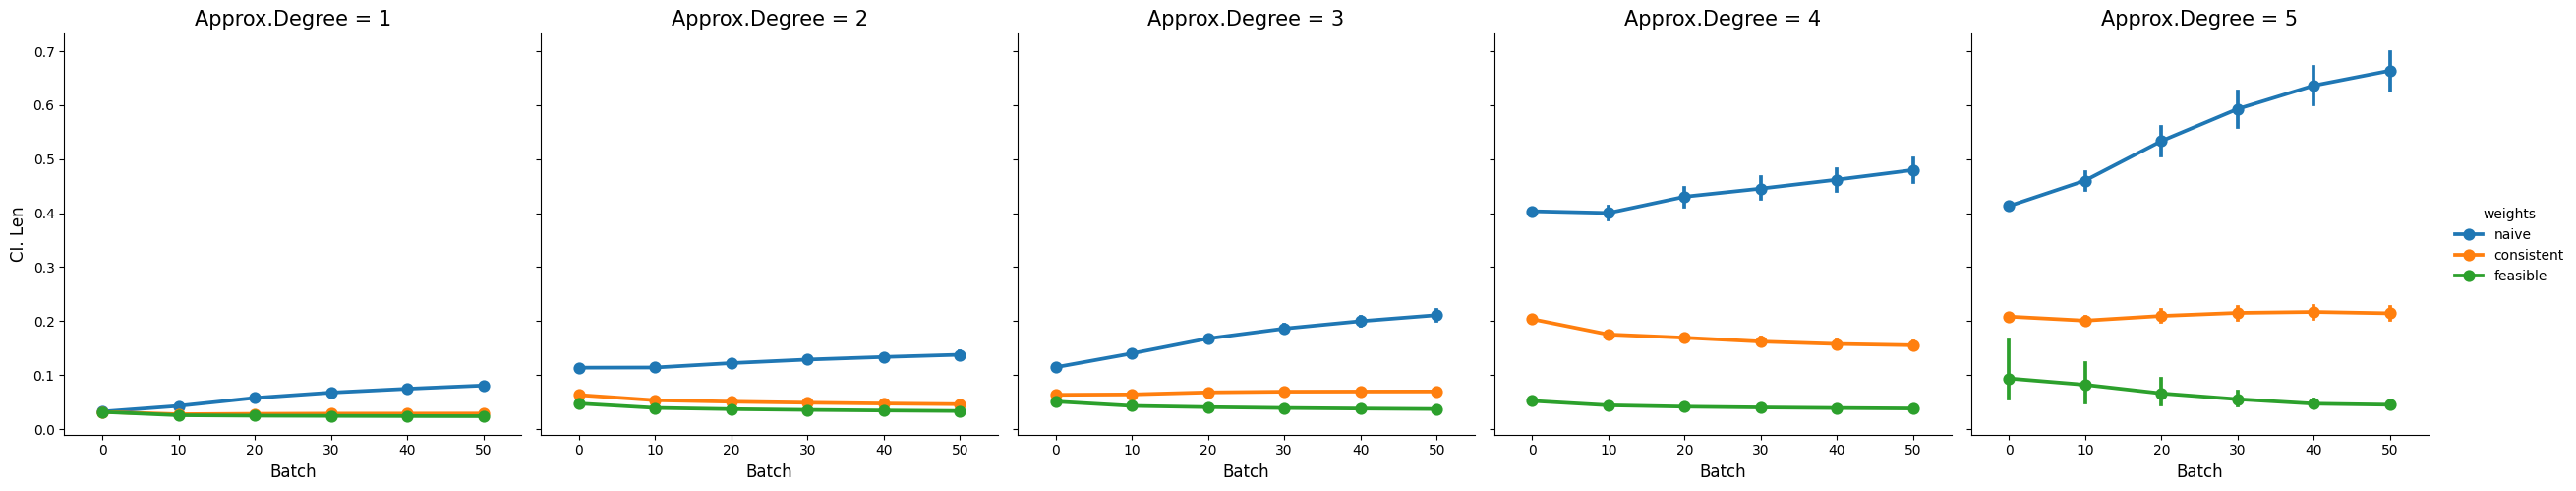

In [47]:
plot_misspec(df_params_misspec, 'cov_param', col='approx_degree', baselines=[confidence] * 5, col_wrap=5, yname=f'{int(confidence * 100)}% Coverage')
plt.savefig('./plots/misspec_cov.pdf')
plot_misspec(df_params_misspec, 'std',  col='approx_degree', estimator=lambda x:4*np.mean(x), col_wrap=5, yname='CI. Len')
plt.savefig('./plots/misspec_ci.pdf')

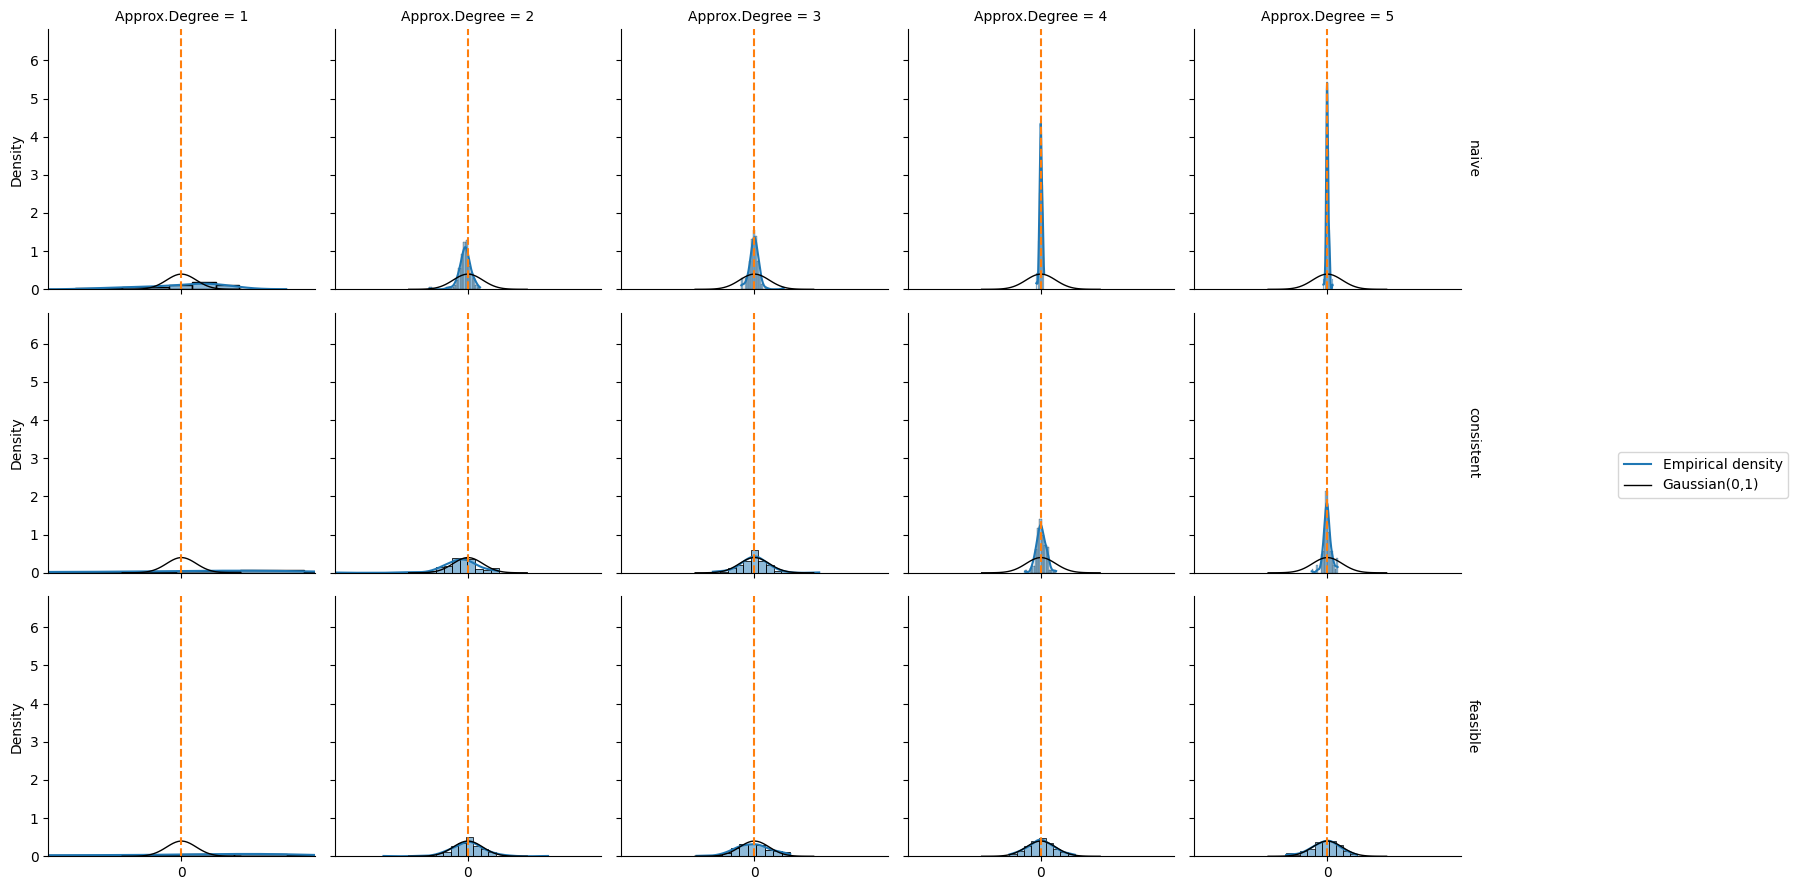

In [48]:
df = df_params_misspec.query("batch==50")
g = sns.FacetGrid(row="weights",
                  sharex=True,
                  sharey=True,
                  col='approx_degree',
                  #ylim=(0, .8),
                  xlim=(-9, 9),
                  #margin_titles=True,
                  data=df,
                  margin_titles=True)
g = g.map(sns.histplot, 'tstat_param', kde=True, stat="density")
xs = np.linspace(-4, 4)
means = [df.query("weights=='naive'")['tstat_param'].mean()]
for ax in  g.axes.flatten():
    ax.plot(xs, norm.pdf(xs),label='N(0,1)', **{"color":"black", "linestyle":"-", "linewidth":1})
    ax.set(xlabel="")
    ax.axvline(x=0, color="tab:orange", ls="--")
    ax.set_xticks([0])
handles, labels = g._legend_data.values(), g._legend_data.keys()
g.fig.legend(labels=['Empirical density', 'Gaussian(0,1)'],  bbox_to_anchor= (1.2, 0.5))
g.fig.tight_layout()
g.set_titles(col_template='Approx.Degree = {col_name}', row_template='{row_name}')
plt.savefig('./plots/misspec_hist.pdf')

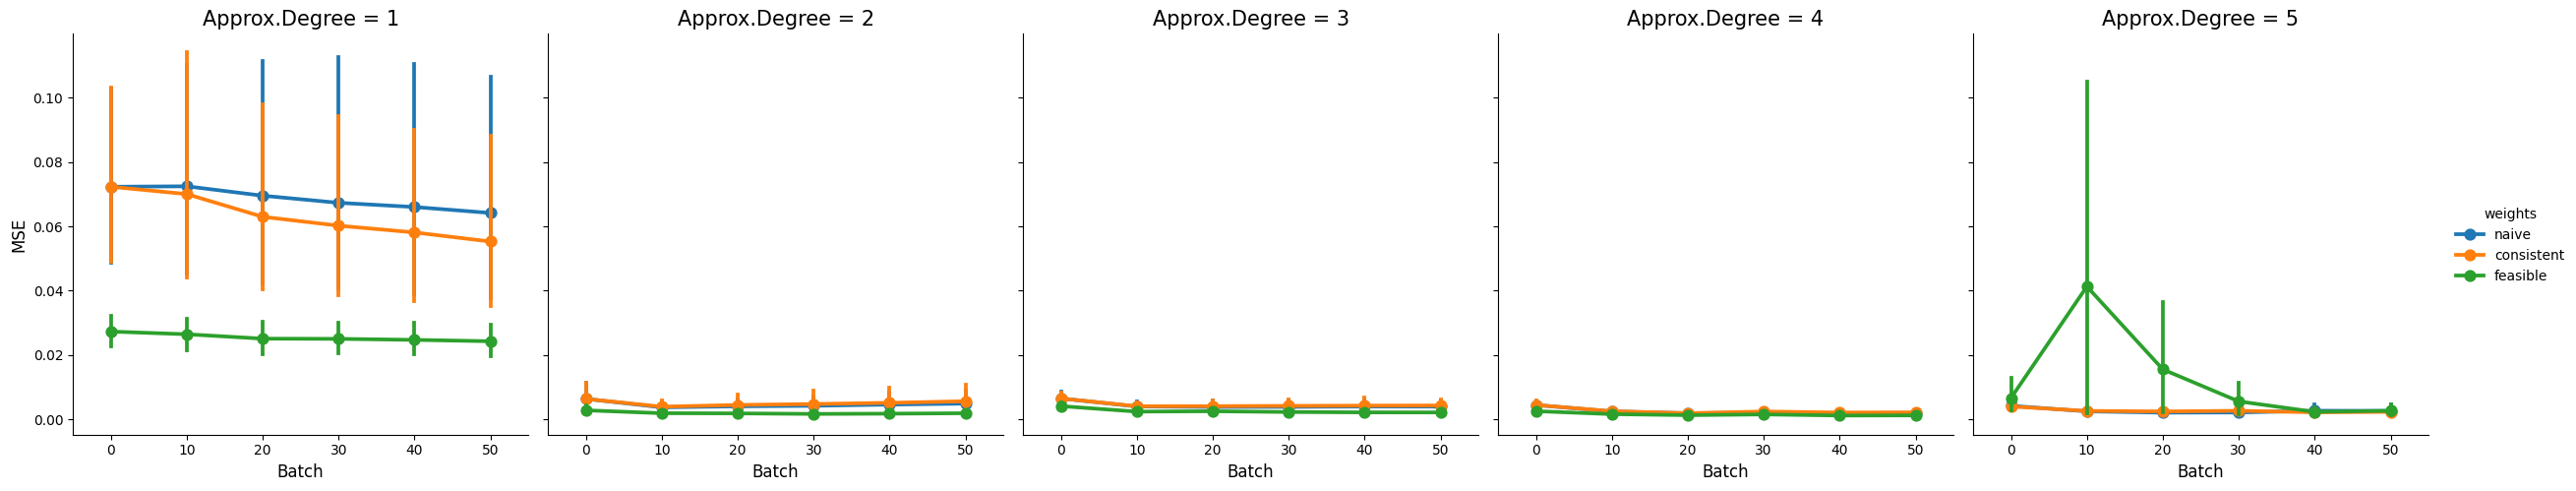

In [49]:
plot_misspec(df_params_misspec, 'mse', yname='MSE',col_wrap=5)
plt.savefig('./plots/misspec_mse.pdf')

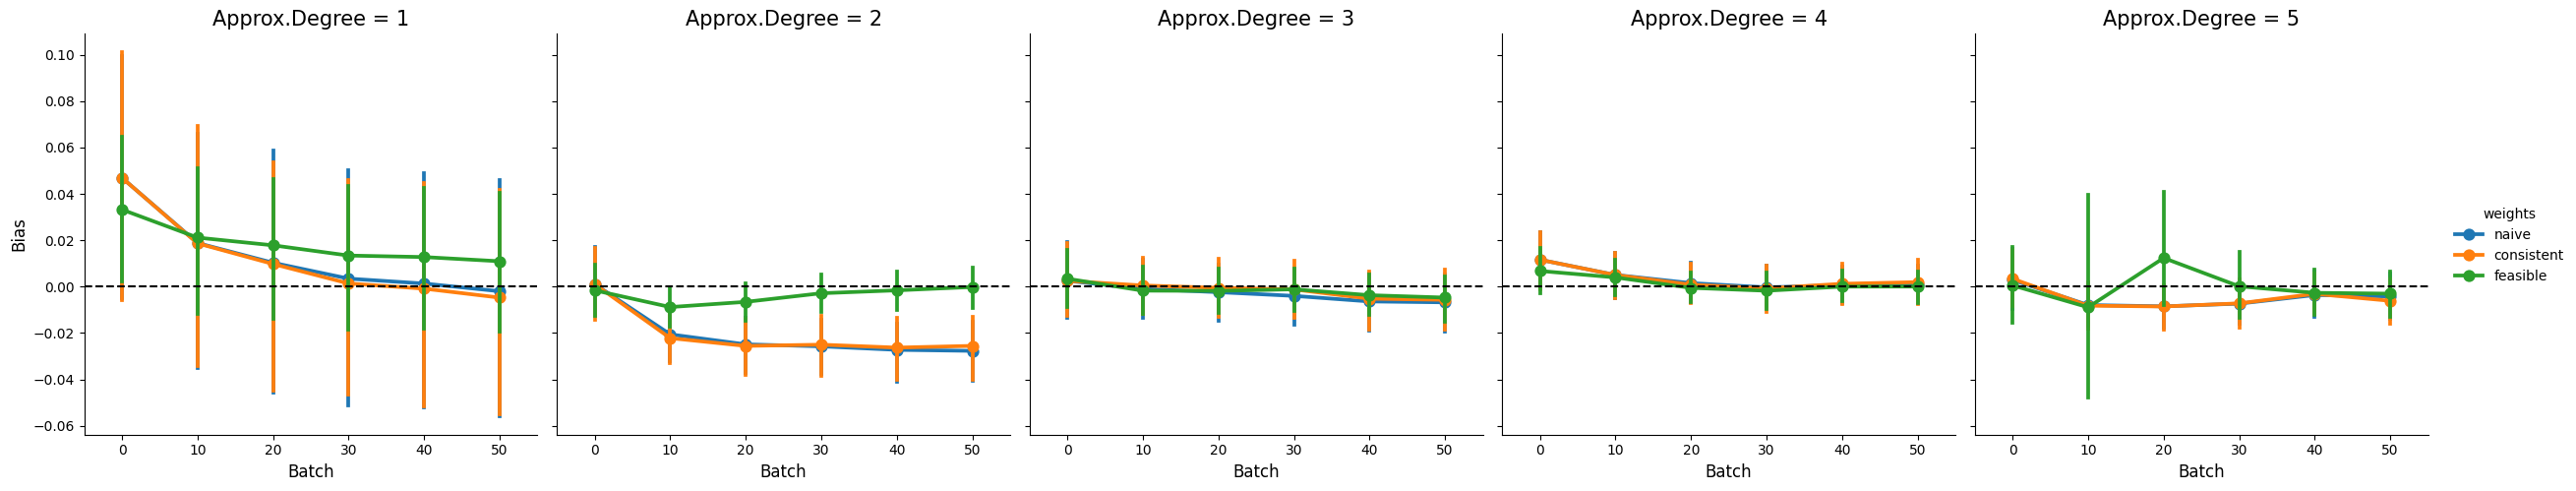

In [50]:
plot_misspec(df_params_misspec, 'error', baselines=[0]*5, col_wrap=5, yname='Bias')
plt.savefig('./plots/misspec_bias.pdf')

In [51]:
df_params.to_csv('./plots/df_params.csv')

In [52]:
df_params_misspec.to_csv('./plots/df_params_misspec.csv')